In [1]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, RobustScaler, StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import boxcox
from sklearn.metrics import f1_score, ConfusionMatrixDisplay,confusion_matrix
from catboost import CatBoostClassifier

from typing import Union


In [2]:
df = pd.read_csv('../data/raw/insurance_dataset.csv')
df = df.drop(axis = 1, labels=['ID']) #Deanonymization

In [3]:
test_df = pd.read_csv('../data/raw/test_set.csv')
test_df = test_df.drop(axis = 1, labels=['ID']) #Deanonymization

In [107]:
y = ['CLAIM?']
new_categorical = ['AGE', 'GENDER', 'DRIVING_EXPERIENCE', 'EDUCATION', 'VEHICLE_YEAR', 'INCOME', 'VEHICLE_TYPE', 'CLIENT LOCATION']
old_categorical = ['MARRIED', 'CHILDREN', 'VEHICLE_OWNERSHIP',]
drop = ['ID']
numerical = ['ANNUAL_MILEAGE', 'CREDIT_SCORE', 'SPEEDING_VIOLATIONS','PAST_ACCIDENTS', 'DUIS' ]

In [67]:
def one_hot_encode(df, columns):
    """
    Encodes Categorical variables
    """
    
    for column in columns:
        temp_df = pd.get_dummies(df[column], prefix = column).astype(int)
        df = pd.concat([df, temp_df], axis = 1)
        df.drop(column, axis = 1, inplace = True)
    return df

def prep_test_df(train_df:pd.DataFrame, test_df:pd.DataFrame):
    
    """ Prepares a dataframe for testing, 
    Function checks if the columns are equal,
    amd adds/removes column names as required.
    """

    training_cols = train_df.columns.to_list()
    test_cols = test_df.columns.to_list()

    if training_cols != test_cols and len(training_cols) > len(test_cols):
        diff = set(training_cols).difference(test_cols)
        
        for x in diff:
            if train_df[x].dtype == 'O':
                test_df[x] = 0

    return test_df[training_cols]

def evaluate(model, eval_df, eval_labels):
    
    """
    Evaluates a model performance on dataset,
    Input are  model, a dataframe, and labels
    """
    y_eval_pred = model.predict(eval_df)
    f1 = f1_score(y_eval_pred.tolist(), eval_labels)

    print("The f1 score is {}".format(f1))
    ConfusionMatrixDisplay.from_predictions(y_eval_pred, eval_labels)
    return f1


def check_wrong_predictions(pred_labels, eval_df, eval_labels)-> pd.DataFrame:
    
    """
    Checks wrong prediction of model on datapoints, in an attempt
    to analyse
    """
    indexes = []
    
    for index,(a,b) in enumerate(zip(pred_labels, eval_labels)):
        if a != b:
            indexes.append(index)
    
    print(indexes)
    temp_df = eval_df.iloc[indexes, :]

    temp_df['pred_label'] = a
    temp_df['correct_label'] = b

    return temp_df


def preproc_pipeline(df, target = Union[None, str]):

    ## add more preprocessing step
    df = one_hot_encode(df,new_categorical)

    labels = []
    if target and target in df.columns.to_list():
        labels = df[target]
        df.drop(columns= target, axis= 1, inplace= True)
    
    return df,labels 

Training machine learning model with only categorical variables and having specialised models for each age group

In [6]:
df['AGE'].unique()

array(['65+', '16-25', '26-39', '40-64'], dtype=object)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9661 entries, 0 to 9660
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   AGE                  9661 non-null   object 
 1   GENDER               9661 non-null   object 
 2   DRIVING_EXPERIENCE   9661 non-null   object 
 3   EDUCATION            9661 non-null   object 
 4   INCOME               9661 non-null   object 
 5   CREDIT_SCORE         8710 non-null   float64
 6   VEHICLE_OWNERSHIP    9661 non-null   int64  
 7   VEHICLE_YEAR         9661 non-null   object 
 8   MARRIED              9661 non-null   int64  
 9   CHILDREN             9661 non-null   int64  
 10  CLIENT LOCATION      9661 non-null   int64  
 11  ANNUAL_MILEAGE       8737 non-null   float64
 12  VEHICLE_TYPE         9661 non-null   object 
 13  SPEEDING_VIOLATIONS  9661 non-null   int64  
 14  DUIS                 9661 non-null   int64  
 15  PAST_ACCIDENTS       9661 non-null   i

In [8]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 339 entries, 0 to 338
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   AGE                  339 non-null    object 
 1   GENDER               339 non-null    object 
 2   DRIVING_EXPERIENCE   339 non-null    object 
 3   EDUCATION            339 non-null    object 
 4   INCOME               339 non-null    object 
 5   CREDIT_SCORE         308 non-null    float64
 6   VEHICLE_OWNERSHIP    339 non-null    int64  
 7   VEHICLE_YEAR         339 non-null    object 
 8   MARRIED              339 non-null    int64  
 9   CHILDREN             339 non-null    int64  
 10  CLIENT LOCATION      339 non-null    int64  
 11  ANNUAL_MILEAGE       306 non-null    float64
 12  VEHICLE_TYPE         339 non-null    object 
 13  SPEEDING_VIOLATIONS  339 non-null    int64  
 14  DUIS                 339 non-null    int64  
 15  PAST_ACCIDENTS       339 non-null    int

## CREATING A MODEL FOR AGE_GROUP 16-25

In [10]:
millenial_df = df[df['AGE'] =='16-25']
millenial_df

,AGE,GENDER,DRIVING_EXPERIENCE,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,CHILDREN,CLIENT LOCATION,ANNUAL_MILEAGE,VEHICLE_TYPE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,CLAIM?
1,16-25,male,0-9y,none,poverty,0.357757,0,before 2015,0,0,10238,16000.0,sedan,0,0,0,1
2,16-25,female,0-9y,high school,working class,0.493146,1,before 2015,0,0,10238,11000.0,sedan,0,0,0,0
3,16-25,male,0-9y,university,working class,0.206013,1,before 2015,0,1,32765,11000.0,sedan,0,0,0,0
13,16-25,female,0-9y,university,upper class,0.591260,1,before 2015,0,1,10238,NaN,sedan,0,0,0,0
17,16-25,male,0-9y,none,poverty,NaN,0,before 2015,1,0,32765,12000.0,sedan,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9647,16-25,male,0-9y,high school,poverty,0.267472,0,before 2015,0,1,10238,13000.0,sedan,0,0,0,1
9651,16-25,female,0-9y,high school,poverty,0.277153,1,before 2015,1,0,21217,15000.0,sedan,0,0,0,1
9657,16-25,male,0-9y,university,poverty,0.489238,0,before 2015,1,1,10238,7000.0,sports car,0,0,0,1
9658,16-25,female,0-9y,university,working class,0.248632,0,before 2015,0,0,10238,11000.0,sedan,0,0,0,1


Using only categorical variables as features

In [122]:
model = CatBoostClassifier(learning_rate=0.02,
                           iterations=1000,
                           depth=10)

def train(df:pd.DataFrame, model:CatBoostClassifier, features):
    train, valid = train_test_split(millenial_df, test_size = 0.3, 
                                        stratify=millenial_df[['CLIENT LOCATION']], 
                                        shuffle=True, random_state= 42)

    train_df,train_labels = preproc_pipeline(train[features],  target="CLAIM?")
    eval_df,eval_labels = preproc_pipeline(valid[features], target="CLAIM?")

    model.fit(train_df,train_labels,use_best_model = True,
        eval_set = tuple((eval_df, eval_labels)),
            verbose = True)

    f1 = evaluate(model, eval_df, eval_labels)
    return model, f1, train_df.columns.to_list()

0:	learn: 0.6805521	test: 0.6814186	best: 0.6814186 (0)	total: 8.48ms	remaining: 8.47s
1:	learn: 0.6676102	test: 0.6714551	best: 0.6714551 (1)	total: 24.7ms	remaining: 12.3s
2:	learn: 0.6573413	test: 0.6611209	best: 0.6611209 (2)	total: 29.1ms	remaining: 9.66s
3:	learn: 0.6466517	test: 0.6505647	best: 0.6505647 (3)	total: 33.7ms	remaining: 8.39s
4:	learn: 0.6361010	test: 0.6403358	best: 0.6403358 (4)	total: 38.1ms	remaining: 7.59s
5:	learn: 0.6251514	test: 0.6324115	best: 0.6324115 (5)	total: 56.5ms	remaining: 9.36s
6:	learn: 0.6173294	test: 0.6242004	best: 0.6242004 (6)	total: 57.2ms	remaining: 8.12s
7:	learn: 0.6073903	test: 0.6153823	best: 0.6153823 (7)	total: 72.7ms	remaining: 9.01s
8:	learn: 0.5980715	test: 0.6071712	best: 0.6071712 (8)	total: 80.5ms	remaining: 8.87s
9:	learn: 0.5888564	test: 0.6001028	best: 0.6001028 (9)	total: 95.6ms	remaining: 9.47s
10:	learn: 0.5809649	test: 0.5923394	best: 0.5923394 (10)	total: 100ms	remaining: 8.99s
11:	learn: 0.5750307	test: 0.5861866	best:

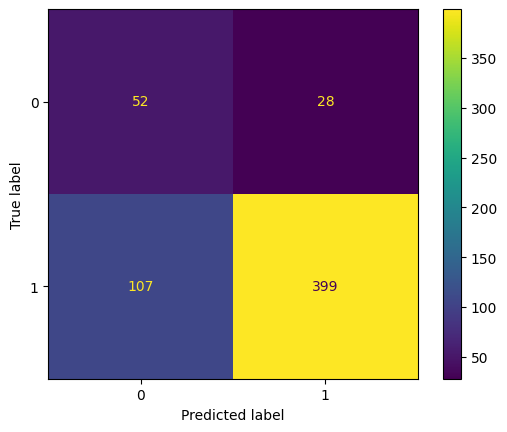

In [124]:
features = new_categorical + ['CLAIM?'] + old_categorical

model_age_16_25, f1_age_16_25 = train(millenial_df, model, features)

### CHECK ON TEST SET

In [125]:
millenial_test_df = test_df[test_df['AGE'] == '16-25']
millenial_test_df,millenial_test_labels = preproc_pipeline(millenial_df[features], target="CLAIM?")

The f1 score is 0.8827586206896552


0.8827586206896552

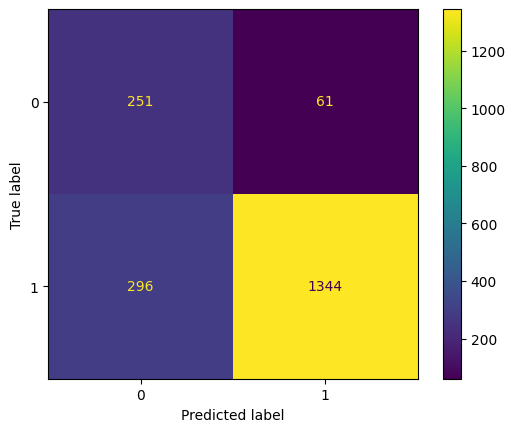

In [126]:
evaluate(model_age_16_25, millenial_test_df, millenial_test_labels)

In [128]:
def feature_importance(features, model):
    for i,j in zip(features, model_age_16_25.get_feature_importance()):
        print(f"The importance of {i} is {j}")
    
feature_importance(features, model_age_16_25)

The importance of AGE is 4.986177524387878
The importance of GENDER is 5.624004650394223
The importance of DRIVING_EXPERIENCE is 27.67753243902876
The importance of EDUCATION is 0.0
The importance of VEHICLE_YEAR is 6.241455967325563
The importance of INCOME is 8.829653213037457
The importance of VEHICLE_TYPE is 0.0
The importance of CLIENT LOCATION is 3.7294050350561414
The importance of CLAIM? is 1.3548154788310907
The importance of MARRIED is 2.2416731287749894
The importance of CHILDREN is 9.920517325991069
The importance of VEHICLE_OWNERSHIP is 7.559147728775932


In [121]:
model.save_model('../models/model_age_16_25.json', format= 'json')